# Cyber Data Analytics, CS4035
## Lab assignment 1: Fraud detection
### April 2019

### Importing data from CSV file

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

data = pd.read_csv('./data_for_student_case.csv', sep = ',')
orig_shape = data.shape
nas = data.isna()
nas_id = np.sum(nas, 1)

print("Amount of nan values in Chargeback: ", np.sum(data['simple_journal'][nas_id > 0] == 'Chargeback'), "\n")


print("NaN values per feature: \n", np.sum(nas, 0), "\n")

# data = data.dropna()

# print("Number of NaN values omitted: ", orig_shape[0] - data.shape[0])

# print(data.dtypes)

labels = data['simple_journal']
print("Number of non-fraud: ", np.sum(labels == 'Settled'), ", with ratio: ", np.sum(labels == 'Settled')/len(labels))
print("Number of fraud: ", np.sum(labels == 'Chargeback'), ", with ratio: ", np.sum(labels == 'Chargeback')/len(labels))
print("Number refused: ", np.sum(labels == 'Refused'), ", with ratio: ", np.sum(labels == 'Refused')/len(labels))

data.groupby(by = 'simple_journal').count()

Amount of nan values in Chargeback:  0 

NaN values per feature: 
 txid                                0
bookingdate                         0
issuercountrycode                 493
txvariantcode                       0
bin                               140
amount                              0
currencycode                        0
shoppercountrycode                482
shopperinteraction                  0
simple_journal                      0
cardverificationcodesupplied    14717
cvcresponsecode                     0
creationdate                        0
accountcode                         0
mail_id                             0
ip_id                               0
card_id                             0
dtype: int64 

Number of non-fraud:  236691 , with ratio:  0.8151021757546956
Number of fraud:  345 , with ratio:  0.0011880901708783602
Number refused:  53346 , with ratio:  0.1837097340744261


,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
simple_journal,,,,,,,,,,,,,,,,
Chargeback,345,345,345,345,345,345,345,345,345,345,345,345,345,345,345,345
Refused,53346,53346,52857,53346,53206,53346,53346,53206,53346,51823,53346,53346,53346,53346,53346,53346
Settled,236691,236691,236687,236691,236691,236691,236691,236349,236691,223497,236691,236691,236691,236691,236691,236691


## Convesion of categorical data to numeric

In [2]:
data_cat = data.copy(True)

data_oneHot = pd.get_dummies(data, columns = ['issuercountrycode', 'txvariantcode', 'currencycode', 'shoppercountrycode', 'shopperinteraction', 'cardverificationcodesupplied', 'accountcode'])

label_mapping = {}

# Convert currency code in order to 'amount' in a single code
label_mapping['currencycode'] = {'SEK': 0.09703, 'MXN': 0.04358, 'AUD': 0.63161, 'NZD': 0.58377, 'GBP':1.13355} 
data.replace({'currencycode' : label_mapping['currencycode']}, inplace=True)
data['amount'] = data['amount'] * data['currencycode']

label_mapping['simple_journal'] = {'Settled': 0, 'Refused' : 0, 'Chargeback' : 1}
data.replace({'simple_journal' : label_mapping['simple_journal']}, inplace=True)

# Convert all the rest columns which are of type 'object'
char_cols = data.dtypes.pipe(lambda x: x[x == 'object']).index

for c in char_cols:
    data[c], label_mapping[c] = pd.factorize(data[c])

label_mapping

{'currencycode': {'SEK': 0.09703,
  'MXN': 0.04358,
  'AUD': 0.63161,
  'NZD': 0.58377,
  'GBP': 1.13355},
 'simple_journal': {'Settled': 0, 'Refused': 0, 'Chargeback': 1},
 'bookingdate': Index(['2015-11-09 14:26:51', '2015-11-09 14:27:38', '2015-11-23 16:34:16',
        '2015-11-23 16:34:51', '2015-11-09 14:26:08', '2015-11-09 14:26:25',
        '2015-11-09 14:26:47', '2015-11-23 16:34:29', '2015-12-08 19:58:35',
        '2015-11-09 14:25:50',
        ...
        '2015-11-03 08:12:13', '2015-11-03 08:12:14', '2015-11-03 22:33:58',
        '2015-11-03 18:57:00', '2015-11-02 20:34:44', '2015-11-02 20:34:30',
        '2015-10-31 20:04:21', '2015-10-31 22:03:39', '2015-11-02 20:16:57',
        '2015-11-03 18:57:01'],
       dtype='object', length=92951),
 'issuercountrycode': Index(['MX', 'US', 'BR', 'CA', 'ES', 'CH', 'SA', 'TH', 'SG', 'NL',
        ...
        'CZ', 'KY', 'CG', 'CM', 'BJ', 'BF', 'CD', 'MV', 'CV', 'JM'],
       dtype='object', length=136),
 'txvariantcode': Index(['mccre

### HeatMap

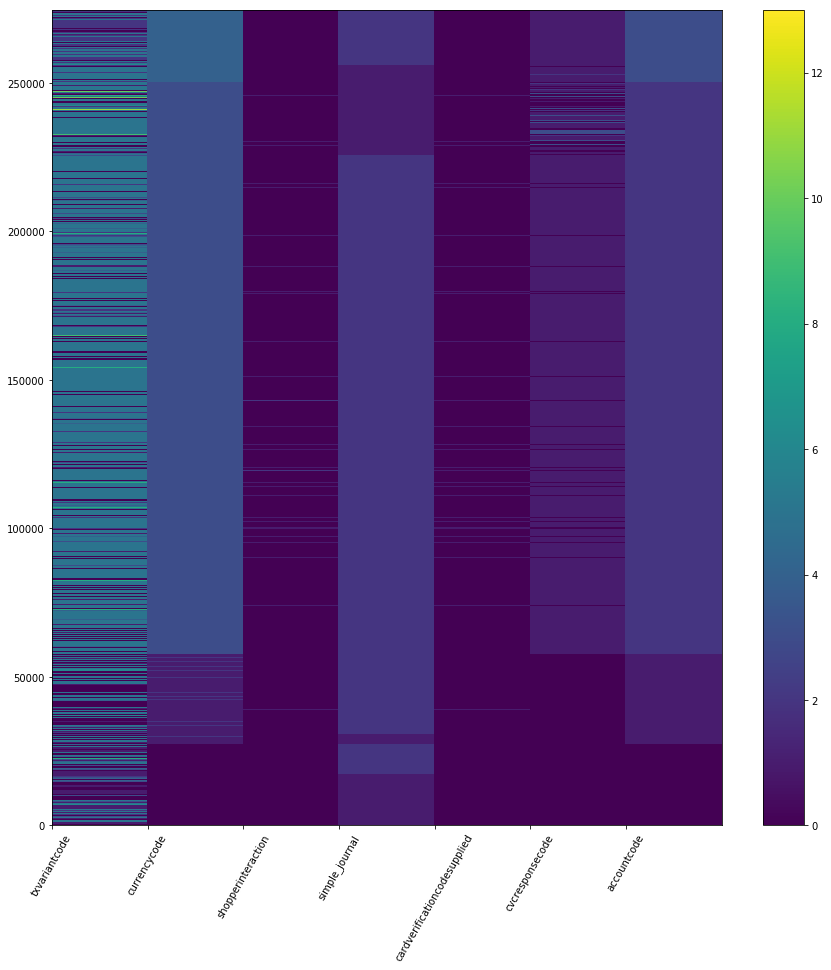

In [33]:
labels = ['txvariantcode', 'currencycode', 'shopperinteraction', 'simple_journal',  
          'cardverificationcodesupplied', 'cvcresponsecode', 'accountcode']

plt.figure(figsize = (15,15))
plt.pcolor(data[labels])
plt.xticks(np.arange(len(labels)), labels, rotation = 60)
plt.colorbar()

### Aggregated values per card id

(223071, 6)


Text(0.5, 1.0, 'Fraud')

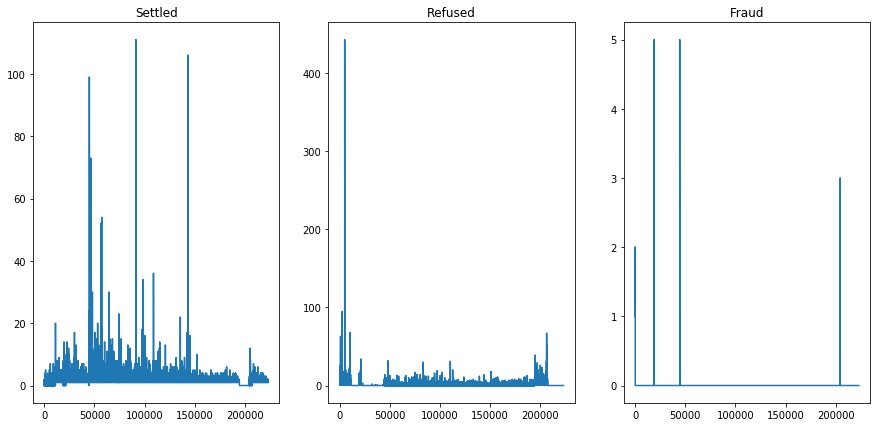

In [32]:
data_agg = data_cat[['card_id', 'simple_journal', 'amount']]

dd = pd.get_dummies(data_agg, columns = ['simple_journal'])

dd['sum_fraud'] = dd['amount'] * dd['simple_journal_Chargeback']
dd['sum_ref'] = dd['amount'] * dd['simple_journal_Refused']
dd['sum_OK'] = dd['amount'] * dd['simple_journal_Settled']

dd_user = dd.groupby(by = 'card_id', sort = False).agg({
    'simple_journal_Settled' : sum,
    'sum_OK' : 'mean',
    'simple_journal_Refused' : sum,
    'sum_ref' : 'mean',
    'simple_journal_Chargeback' : sum,
    'sum_fraud' : 'mean'
})

print(dd_user.values.shape)

# Visualizations
f, ax = plt.subplots(1, 3, figsize = (15,7))
ax[0].plot(dd_user.values[:, 0])
ax[0].set_title("Settled")
ax[1].plot(dd_user.values[:, 2])
ax[1].set_title("Refused")
ax[2].plot(dd_user.values[:, 4])
ax[2].set_title("Fraud")

In [43]:
test = data['bookingdate'].str.extract('(....-..-..)', expand=True)
test
tt = test[0].unique().sort()


None


### Visualizations

Text(0, 0.5, 'mean amount per group')

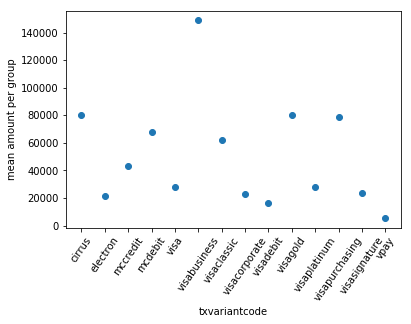

In [35]:
code = data_cat[['txvariantcode', 'amount']].groupby(['txvariantcode']).mean()
code.values
labels = code.index.values
plt.scatter(np.arange(len(code.values)), code.values)
plt.xticks(np.arange(len(code.values)), labels, rotation = '55')
plt.xlabel('txvariantcode')
plt.ylabel('mean amount per group')

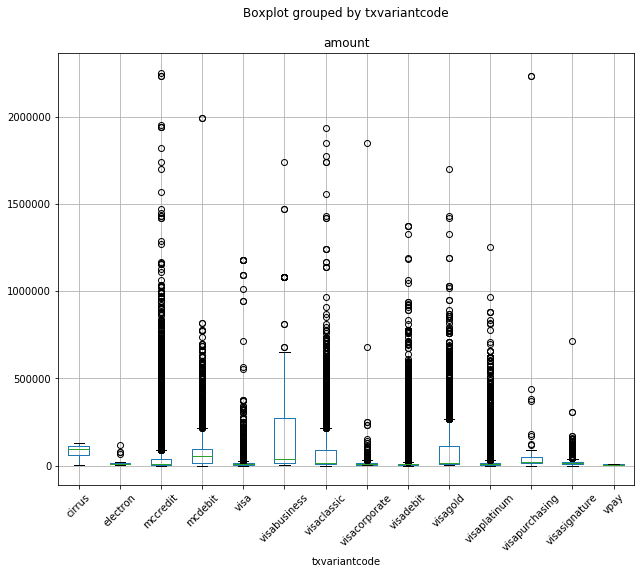

In [36]:
data_cat.boxplot(column = 'amount', by = 'txvariantcode', figsize = (10, 8), rot = '45')

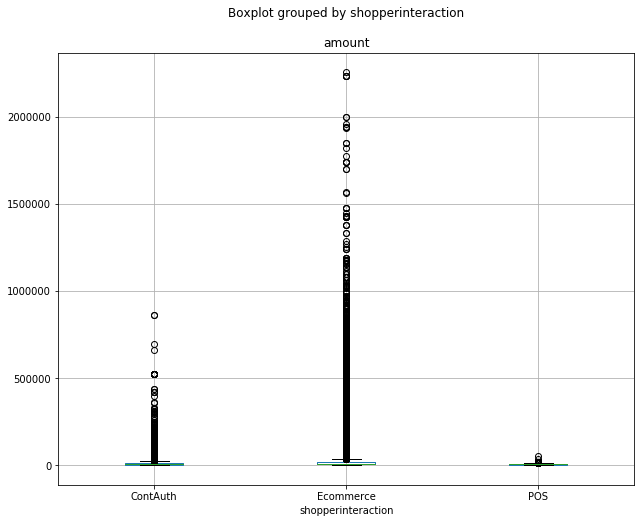

In [38]:
data_cat.boxplot(column = ['amount'], by = 'shopperinteraction', figsize = (10,8))

### Number of IP addresses per card id
#### The more addresses the more suspicious the transactions are

In [40]:
data_cat[['card_id', 'ip_id']].groupby('card_id').nunique().sort_values(by = 'ip_id', ascending = False).head()

,card_id,ip_id
card_id,,
card267365,1,25
card183189,1,25
card11998,1,23
card210128,1,22
card18592,1,20


## Classification

In [3]:
from PlotConfusionMatrix import *
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc
from RocAnalysis import *

X = data.drop(['simple_journal', 'creationdate', 'bookingdate', 'currencycode'], axis = 1).values
y = data['simple_journal'].values

# Imputing missing values.. we could alternatively just remove these samples
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
print(np.sum(np.isnan(X)))
X = imp.fit_transform(X)

imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
X = imp.fit_transform(X)

print("Fraud class samples: ", np.sum(y == 1))
print("Non-fraud class samples: ", np.sum(y == 0))
print("Ratio: ", np.sum(y == 1)/np.sum(y == 0))

# 10-Fold cross validation used for estimating performance
num_splits = 10
cv = StratifiedKFold(n_splits = num_splits)

140
Fraud class samples:  345
Non-fraud class samples:  290037
Ratio:  0.001189503408185852


2053 26951 0 35
28609 395 7 28
28933 71 35 0
28943 61 34 1
28934 70 33 2
28944 60 30 4
28951 53 31 3
28972 31 32 2
28126 877 32 2
29003 0 34 0


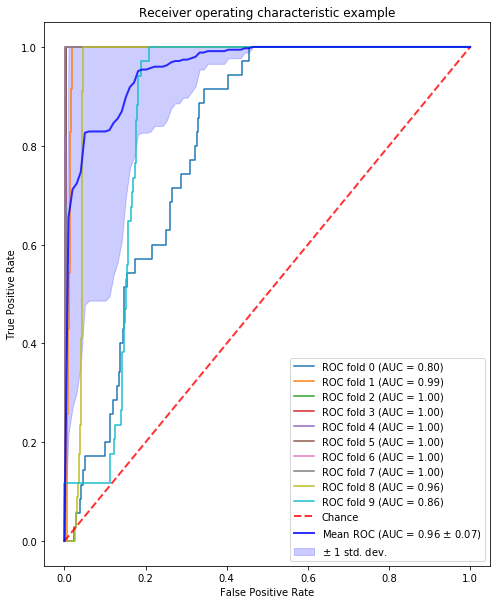

Confusion matrix, without normalization
[[261468  28569]
 [   268     77]]


<Figure size 432x288 with 0 Axes>

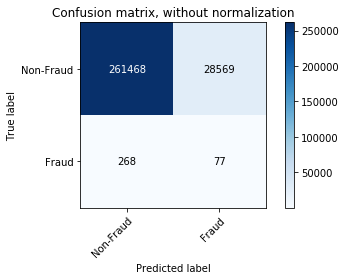

In [4]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
m_tpr, std_tpr, m_auc, std_auc, cm = roc_analysis(X, y, clf, cv, True, False)

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


28972 32 35 0
29002 2 35 0
29004 0 35 0
29004 0 35 0
29004 0 35 0
29004 0 34 0
29004 0 34 0
29003 0 34 0
28995 8 34 0
29003 0 34 0


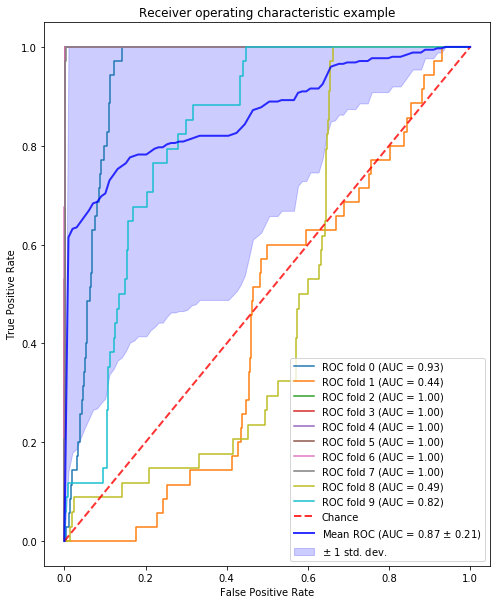

Confusion matrix, without normalization
[[289995     42]
 [   345      0]]


<Figure size 432x288 with 0 Axes>

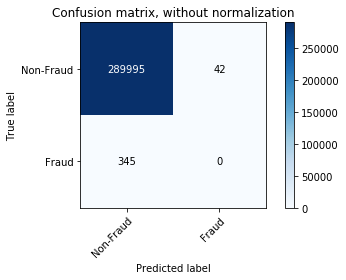

In [5]:
from  sklearn.linear_model import LogisticRegression as LR

clf = LR(solver = 'lbfgs', multi_class = 'auto')
m_tpr, std_tpr, m_auc, std_auc, cm = roc_analysis(X, y, clf, cv, True, False)

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1549 27455 0 35
28996 8 0 35
29003 1 0 35
29004 0 0 35
29004 0 21 14
29004 0 0 34
29004 0 0 34
29003 0 11 23
29003 0 19 15
29003 0 34 0


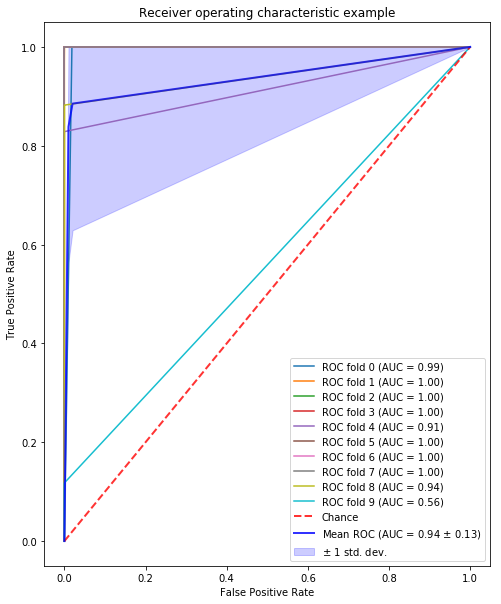

Confusion matrix, without normalization
[[262573  27464]
 [    85    260]]


<Figure size 432x288 with 0 Axes>

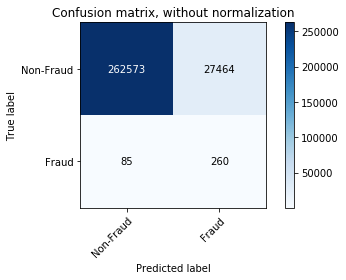

In [6]:
from  sklearn.ensemble import RandomForestClassifier as RF

clf = RF(n_estimators='warn', criterion='gini', min_samples_split=2, min_samples_leaf=1, 
         min_weight_fraction_leaf=0.0, max_features='auto', min_impurity_decrease=0.0, 
         bootstrap=True, n_jobs=-1, verbose=0, warm_start=False)
m_tpr, std_tpr, m_auc, std_auc, cm = roc_analysis(X, y, clf, cv, True, False)

1413 27591 0 35
28851 153 35 0
28981 23 35 0
28982 22 35 0
28982 22 35 0
28990 14 34 0
28994 10 34 0
28996 7 34 0
28677 326 34 0
29001 2 34 0


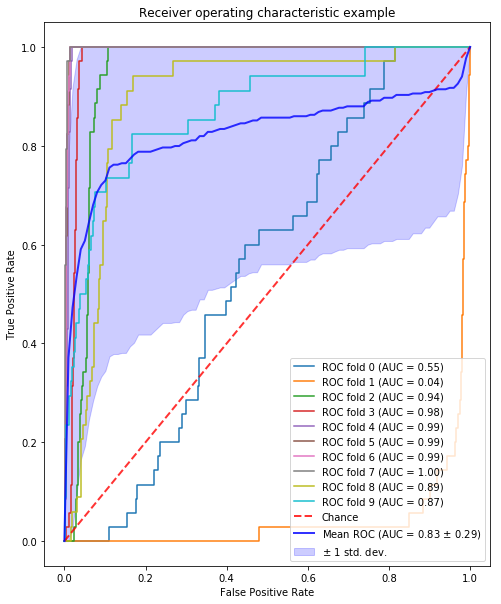

Confusion matrix, without normalization
[[261867  28170]
 [   310     35]]


<Figure size 432x288 with 0 Axes>

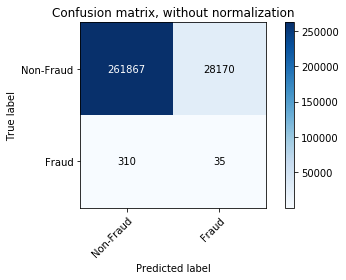

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

clf = LDA(solver='svd')
m_tpr, std_tpr, m_auc, std_auc, cm = roc_analysis(X, y, clf, cv, True, False)

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


28759 245 0 35
29004 0 35 0


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


28355 649 2 33
28998 6 0 35


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


29004 0 31 4
29004 0 14 20


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


29004 0 0 34
29003 0 32 2


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


29003 0 32 2
29003 0 31 3


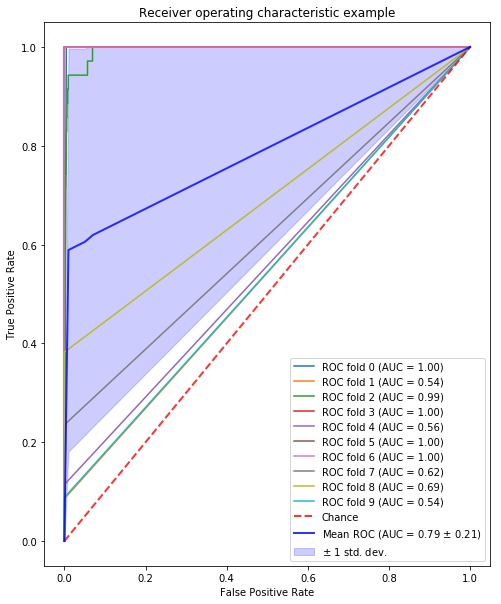

Confusion matrix, without normalization
[[289137    900]
 [   177    168]]


<Figure size 432x288 with 0 Axes>

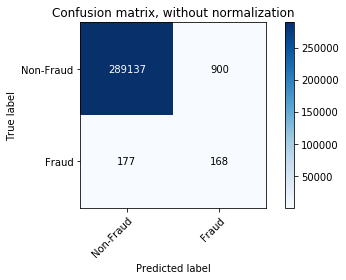

In [8]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

clf = QDA()
m_tpr, std_tpr, m_auc, std_auc, cm = roc_analysis(X, y, clf, cv, True, False)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNN

clf = KNN(n_neighbors=5, weights='distance', algorithm='auto', leaf_size=30, p=2, metric='minkowski', n_jobs=-1)
m_tpr, std_tpr, m_auc, std_auc, cm = roc_analysis(X, y, clf, cv, True, False)

633 28371 0 35
29004 0 0 35
14471 14533 0 35
29004 0 0 35
29004 0 26 9
29004 0 0 34
29004 0 0 34
29003 0 0 34
29003 0 28 6
29003 0 31 3


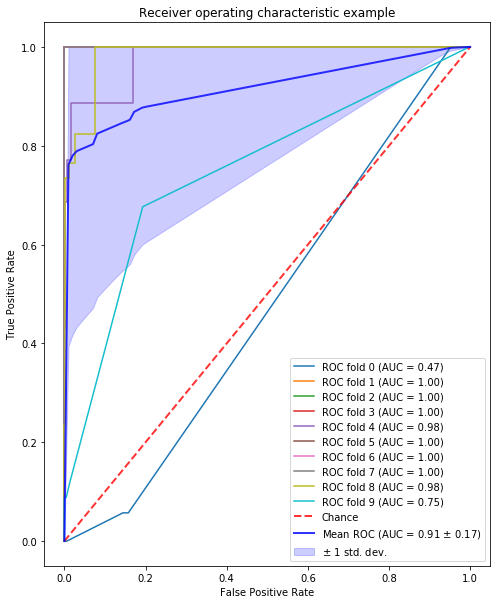

Confusion matrix, without normalization
[[247133  42904]
 [    85    260]]


<Figure size 432x288 with 0 Axes>

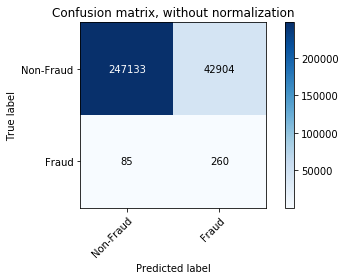

In [10]:
from sklearn.ensemble import AdaBoostClassifier as AdaBoost

clf = AdaBoost(n_estimators=50, learning_rate=1.0, algorithm='SAMME.R')
m_tpr, std_tpr, m_auc, std_auc, cm = roc_analysis(X, y, clf, cv, True, False)

### Dimensionality Reduction & Scaling

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as StandardScaler

ss = StandardScaler()
X_scaled = ss.fit_transform(X)

pca = PCA(n_components=0.95, whiten = True)
X_pca = pca.fit_transform(X_scaled)
pca.n_components_

7

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1247 27757 0 35
29004 0 0 35
17593 11411 0 35
29004 0 0 35
29004 0 16 19
29004 0 0 34
29004 0 0 34
29003 0 15 19
29002 1 29 5
29003 0 32 2


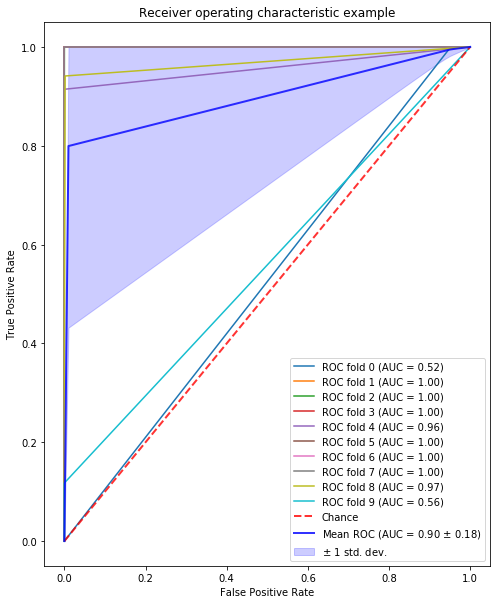

Confusion matrix, without normalization
[[250868  39169]
 [    92    253]]


<Figure size 432x288 with 0 Axes>

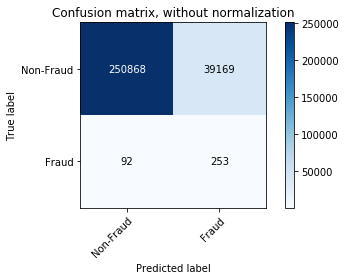

In [13]:
from sklearn.neighbors import KNeighborsClassifier as KNN

clf = RF(n_estimators='warn', criterion='gini', min_samples_split=2, min_samples_leaf=1, 
         min_weight_fraction_leaf=0.0, max_features='auto', min_impurity_decrease=0.0, 
         bootstrap=True, n_jobs=-1, verbose=0, warm_start=False)
m_tpr, std_tpr, m_auc, std_auc, cm = roc_analysis(X, y, clf, cv, True, False)